In [49]:
import sys
sys.path.append('../../')

import numpy as np
from qiskit import IBMQ, Aer, QuantumCircuit
import matplotlib.pyplot as plt
import QuantumTomography as qt 
from main import device_process_measurement_tomography, Quantities, Cross_Quantities, measurement_process_tomography, tomographic_gate_set_tomography
from qiskit.compiler import transpile
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.providers.aer.noise import NoiseModel
from utils_plots import *

In [2]:
IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='csic-1', project='main')

In [3]:
backend = provider.get_backend('ibm_perth')
simulator = Aer.get_backend('aer_simulator')
job_manager = IBMQJobManager() 

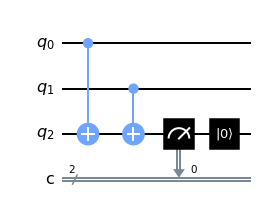

In [4]:
qc = QuantumCircuit(3,2)
qc.cx(0,2)
qc.cx(1,2)
qc.measure(2,0)
qc.reset(2)
qc.draw(output='mpl')

In [5]:
gst = tomographic_gate_set_tomography( 2 )
mpt = measurement_process_tomography( 2, 1, 1 ) 
qcs = mpt.circuits( qc )
qcs0 = gst.circuits()
results = simulator.run(qcs,shots=1e3).result()
# gate_set = gst.fit( results )
results_mpt = mpt.fit( results )

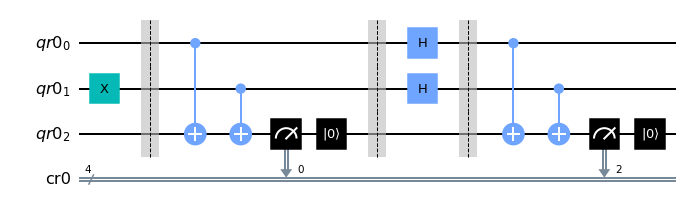

In [6]:
qcs[13].draw(output='mpl')

In [7]:
qcs_t = transpile( qcs, backend, initial_layout=[0,2,1] )
qcs0_t  = transpile( qcs0, backend, initial_layout=[0,2] )
qc_t = qcs_t + qcs0_t

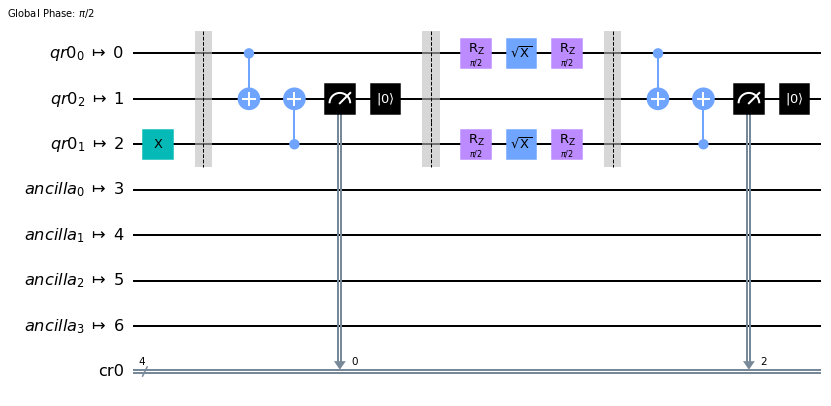

In [8]:
qcs_t[13].draw(output='mpl')

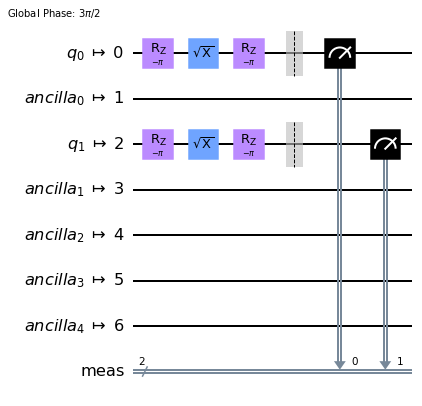

In [9]:
qcs0_t[12].draw(output='mpl')

In [10]:
# for _ in range(5):
#     job = job_manager.run( qc_t, backend=backend, shots=2**13 )
#     print( job.job_set_id() )

# 5992991611d94134a162532567eafd22-16656208124901643
# 9f5c7a238b594add9ef43ca9cf64b846-16656208124901643
# 3d5fc22f113043d59e0c889dda029e41-16656208125831845
# 7e0adc3924e349ad921b9c48a62a7ef2-1665620812625193
# 3452eead7dc44508ac77f7fc9c6d4029-16656208126672032

In [11]:
jobs_id = [
            '5992991611d94134a162532567eafd22-16656208124901643',
            '9f5c7a238b594add9ef43ca9cf64b846-16656208124901643',
            '3d5fc22f113043d59e0c889dda029e41-16656208125831845',
            '7e0adc3924e349ad921b9c48a62a7ef2-1665620812625193',
            '3452eead7dc44508ac77f7fc9c6d4029-16656208126672032']

In [12]:
results = []
for job_id in jobs_id:
    job = job_manager.retrieve_job_set(job_id, provider)
    results.append( job.results().combine_results() )


In [61]:
chois = []
povms = []
for j in range(5):
    results_gst = gst.fit( results[j] )
    gate_set = [results_gst.states, results_gst.measurements, results_gst.processes ] 
    results_mpt = mpt.fit( results[j], gate_set= gst.gateset2spam( gate_set ) )
    chois.append( results_mpt.chois[0] )
    povms.append( results_mpt.povms[0] )

In [62]:
povmsm = np.mean( povms, 0 ).reshape(4,4,4)

In [63]:
np.sum( povmsm, 2 )

array([[1.00000525e+00+0.00000000e+00j, 3.19271274e-06-6.13076372e-07j,
        9.47927225e-06-1.33726744e-06j, 1.83506148e-07-3.58482211e-09j],
       [3.19271274e-06+6.13076372e-07j, 1.00000361e+00+0.00000000e+00j,
        1.94812999e-07-2.86614956e-08j, 9.35801498e-06-1.31678835e-06j],
       [9.47927225e-06+1.33726744e-06j, 1.94812999e-07+2.86614956e-08j,
        9.99996361e-01+0.00000000e+00j, 3.01344107e-06-5.74061342e-07j],
       [1.83506148e-07+3.58482211e-09j, 9.35801498e-06+1.31678835e-06j,
        3.01344107e-06+5.74061342e-07j, 9.99994779e-01+0.00000000e+00j]])

[<Axes3DSubplot:>, <Axes3DSubplot:>]

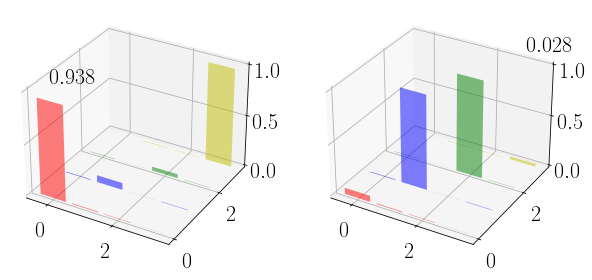

In [64]:
Plot_Chois( povmsm[:,:,[0,2]].transpose(2,0,1), z_lim=1  )

In [65]:
choism = np.mean( chois, 0 )

In [66]:
qt.PartialTrace(  qt.Process2Choi( choism[2] ), [4,4], 0 )

array([[ 6.23420050e-02+0.j        , -6.91488430e-03+0.00395657j,
        -4.05068948e-03+0.00265092j,  7.26248241e-04-0.00085315j],
       [-6.91488430e-03-0.00395657j,  9.31569557e-01+0.j        ,
        -2.99417893e-04-0.00106068j,  3.44427016e-03-0.00322932j],
       [-4.05068948e-03-0.00265092j, -2.99417893e-04+0.00106068j,
         9.61529154e-01+0.j        , -1.93459729e-03-0.00301446j],
       [ 7.26248241e-04+0.00085315j,  3.44427016e-03+0.00322932j,
        -1.93459729e-03+0.00301446j,  2.86932755e-02+0.j        ]])

In [67]:
povmsm[:,:,2]

array([[ 6.19652731e-02+0.j        , -6.92002210e-03-0.00395641j,
        -4.07580427e-03-0.00264573j,  7.23983554e-04+0.00086197j],
       [-6.92002210e-03+0.00395641j,  9.31195711e-01+0.j        ,
        -2.99486262e-04+0.00106027j,  3.41958420e-03+0.00323058j],
       [-4.07580427e-03+0.00264573j, -2.99486262e-04-0.00106027j,
         9.61167847e-01+0.j        , -1.94493982e-03+0.00301029j],
       [ 7.23983554e-04-0.00086197j,  3.41958420e-03-0.00323058j,
        -1.94493982e-03-0.00301029j,  2.83355354e-02+0.j        ]])

[<Axes3DSubplot:>, <Axes3DSubplot:>, <Axes3DSubplot:>, <Axes3DSubplot:>]

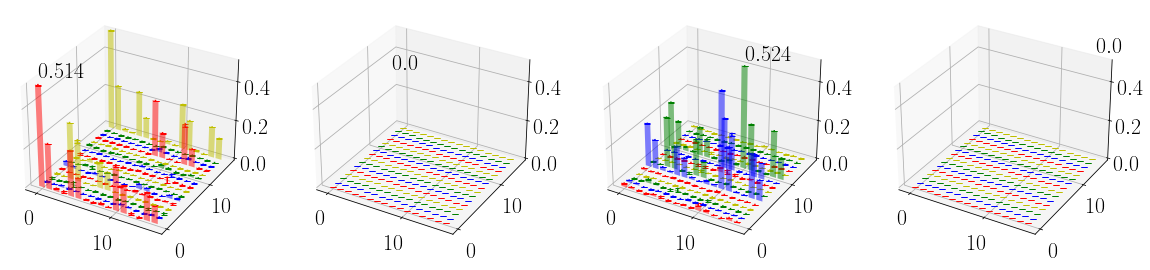

In [68]:
Plot_Chois( choism, np.std( chois, axis=0 ), z_lim=0.5  )

In [69]:
psi1 = np.array([ 1, 0, 0, 1 ])/np.sqrt(2)
rho1 = np.outer( psi1, psi1.conj() ).flatten()
psi2 = np.array([ 0, 1, 1, 0 ])/np.sqrt(2)
rho2 = np.outer( psi2, psi2.conj() ).flatten()

In [70]:
choim0 = np.mean( chois, 0 )[0]
choim2 = np.mean( chois, 0 )[2]

In [71]:
rho10 = choim0@rho1
rho1, rho10, np.trace( rho10.reshape(4,4)  ) 

(array([0.5, 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5,
        0. , 0. , 0.5]),
 array([0.51492264+0.j        , 0.16530054+0.16801377j,
        0.15123441-0.0128261j , 0.0819265 +0.06812933j,
        0.16530054-0.16801377j, 0.10789943+0.j        ,
        0.0438453 -0.0532166j , 0.04816995-0.00497508j,
        0.15123441+0.0128261j , 0.0438453 +0.0532166j ,
        0.2317389 +0.j        , 0.10779122+0.10689429j,
        0.0819265 -0.06812933j, 0.04816995+0.00497508j,
        0.10779122-0.10689429j, 0.09983576+0.j        ]),
 (0.95439674375293+0j))

In [72]:
rho20 = choim0@rho2
rho2, choim0@rho2 , np.trace( rho20.reshape(4,4)  ) 

(array([0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0.5, 0.5, 0. , 0. ,
        0. , 0. , 0. ]),
 array([0.01825961+0.00000000e+00j, 0.00595815+6.05373672e-03j,
        0.00826151+1.72261588e-04j, 0.0034996 +3.60594458e-03j,
        0.00595815-6.05373672e-03j, 0.00395772+0.00000000e+00j,
        0.00275879-2.73844186e-03j, 0.00236737-4.08269873e-06j,
        0.00826151-1.72261588e-04j, 0.00275879+2.73844186e-03j,
        0.0234755 +0.00000000e+00j, 0.01010085+1.01003388e-02j,
        0.0034996 -3.60594458e-03j, 0.00236737+4.08269873e-06j,
        0.01010085-1.01003388e-02j, 0.00869657+0.00000000e+00j]),
 (0.05438939618906982+0j))